# Music Genre Classification using Audio Features

### Uses these libraries `torch`, `pandas`, `scipy`, `evaluate`, `numpy`, `sklearn` and `datasets`

### 1. Import the libraries

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

import evaluate
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Done with this


#### Set random seed for reproducibility

In [12]:
torch.manual_seed(42)
np.random.seed(42)

### 2. Load the GTZAN dataset from Hugging Face 

In [13]:
print("Loading dataset...")
dataset = load_dataset("marsyas/gtzan", "audio")

print("Done with this")

Loading dataset...
Done with this


#### Create our own train/test split since the dataset only has `train`

In [14]:
full_dataset = dataset['train']
train_test_split = full_dataset.train_test_split(test_size=0.1, seed=42)

#### Get audio features using librosa

In [15]:
def extract_features(audio_array, sample_rate):
    # Import librosa here to avoid conflicts
    import librosa
    
    # Extract various audio features
    # Mel-frequency cepstral coefficients
    mfccs = librosa.feature.mfcc(y=audio_array, sr=sample_rate, n_mfcc=13)
    
    # Spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_array, sr=sample_rate)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_array, sr=sample_rate)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_array, sr=sample_rate)[0]
    
    # Rhythm features
    tempo, _ = librosa.beat.beat_track(y=audio_array, sr=sample_rate)
    
    # Zero crossing rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio_array)[0]
    
    # Compute statistics for each feature
    features = {}
    
    # MFCC stats
    for i in range(mfccs.shape[0]):
        features[f'mfcc{i+1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc{i+1}_std'] = np.std(mfccs[i])
        features[f'mfcc{i+1}_skew'] = stats.skew(mfccs[i])
        features[f'mfcc{i+1}_kurtosis'] = stats.kurtosis(mfccs[i])
    
    # Other features stats
    for name, feature in [
        ('spectral_centroid', spectral_centroid),
        ('spectral_bandwidth', spectral_bandwidth), 
        ('spectral_rolloff', spectral_rolloff),
        ('zero_crossing_rate', zero_crossing_rate)
    ]:
        features[f'{name}_mean'] = np.mean(feature)
        features[f'{name}_std'] = np.std(feature)
        features[f'{name}_skew'] = stats.skew(feature)
        features[f'{name}_kurtosis'] = stats.kurtosis(feature)
    
    # Add tempo
    features['tempo'] = tempo
    
    return features

Done with this


#### Process audio files and extract features

In [16]:
def process_dataset(dataset_split):
    features_list = []
    labels = []
    
    for item in dataset_split:
        audio = item['audio']
        audio_array = audio['array']
        sample_rate = audio['sampling_rate']
        genre = item['genre']
        
        # Extract features
        features = extract_features(audio_array, sample_rate)
        features_list.append(features)
        labels.append(genre)
    
    # Convert to DataFrame
    df = pd.DataFrame(features_list)
    
    return df, labels

Done with this


#### Process a smaller subset for quick demonstration (adjust as needed)

In [17]:
print("Extracting audio features (this may take a while)...")
train_size = 300  # Adjust based on your computational resources
test_size = 100

Extracting audio features (this may take a while)...
Done with this


#### Randomly sample from the dataset

In [18]:
train_subset = train_test_split['train'].select(range(min(train_size, len(train_test_split['train']))))
test_subset = train_test_split['test'].select(range(min(test_size, len(train_test_split['test']))))

Done with this


#### Extract features

In [19]:
X_train, y_train = process_dataset(train_subset)
X_test, y_test = process_dataset(test_subset)

Done with this


#### Create label mapping

In [20]:
label_mapping = {label: idx for idx, label in enumerate(sorted(set(y_train)))}
inv_label_mapping = {idx: label for label, idx in label_mapping.items()}

#### Convert labels to indices

In [21]:
y_train_indices = [label_mapping[label] for label in y_train]
y_test_indices = [label_mapping[label] for label in y_test]

### 3. Create PyTorch dataset class

In [22]:
class MusicDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

#### Scale features

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Create datasets and dataloaders

In [24]:
train_dataset = MusicDataset(X_train_scaled, y_train_indices)
test_dataset = MusicDataset(X_test_scaled, y_test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### 4. Define the neural network model

In [25]:
class MusicGenreClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MusicGenreClassifier, self).__init__()
        
        # Architecture with dropout for regularization
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

### 5. Training function

In [26]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        accuracy = correct / total
        val_accuracies.append(accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {accuracy:.4f}')
    
    return train_losses, val_losses, val_accuracies

### 6. Evaluate model function

In [35]:
def evaluate_model(model, test_loader):
    # Initialize evaluate metric
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")
    
    all_preds = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics using evaluate
    accuracy = accuracy_metric.compute(predictions=all_preds, references=all_labels)
    f1 = f1_metric.compute(predictions=all_preds, references=all_labels, average='macro')
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Print classification report
    print("\nClassification Report:")
    genre_names = [str(inv_label_mapping[i]) for i in range(len(inv_label_mapping))]
    print(classification_report(all_labels, all_preds, target_names=genre_names))
    
    return accuracy, f1, cm, all_preds, all_labels

#### Import scikit-learn's train_test_split explicitly

In [36]:
from sklearn.model_selection import train_test_split as sklearn_train_test_split

#### Then use it with the explicit name. Split training data into training and validation. 

In [37]:
X_train_final, X_val, y_train_final, y_val = sklearn_train_test_split(
    X_train_scaled, y_train_indices, test_size=0.2, random_state=42
)

#### Create datasets for final training

In [38]:
train_final_dataset = MusicDataset(X_train_final, y_train_final)
val_dataset = MusicDataset(X_val, y_val)

train_final_loader = DataLoader(train_final_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#### Initialize model, loss function, and optimizer

In [39]:
input_size = X_train.shape[1]  # Number of features
num_classes = len(label_mapping)
model = MusicGenreClassifier(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

#### Train the model

In [40]:
print("\nTraining the model...")
train_losses, val_losses, val_accuracies = train_model(
    model, criterion, optimizer, train_final_loader, val_loader, num_epochs=15
)


Training the model...
Epoch 1/15, Train Loss: 2.3482, Val Loss: 2.2483, Val Accuracy: 0.2167
Epoch 2/15, Train Loss: 1.8717, Val Loss: 2.0905, Val Accuracy: 0.3500
Epoch 3/15, Train Loss: 1.6093, Val Loss: 1.8683, Val Accuracy: 0.4333
Epoch 4/15, Train Loss: 1.4697, Val Loss: 1.6699, Val Accuracy: 0.5333
Epoch 5/15, Train Loss: 1.3327, Val Loss: 1.5460, Val Accuracy: 0.5000
Epoch 6/15, Train Loss: 1.1736, Val Loss: 1.4483, Val Accuracy: 0.5167
Epoch 7/15, Train Loss: 1.0808, Val Loss: 1.3720, Val Accuracy: 0.5667
Epoch 8/15, Train Loss: 1.0012, Val Loss: 1.3129, Val Accuracy: 0.5667
Epoch 9/15, Train Loss: 0.8814, Val Loss: 1.2689, Val Accuracy: 0.5667
Epoch 10/15, Train Loss: 0.8967, Val Loss: 1.2259, Val Accuracy: 0.6167
Epoch 11/15, Train Loss: 0.8081, Val Loss: 1.2153, Val Accuracy: 0.6000
Epoch 12/15, Train Loss: 0.7180, Val Loss: 1.1964, Val Accuracy: 0.6167
Epoch 13/15, Train Loss: 0.6694, Val Loss: 1.1734, Val Accuracy: 0.6333
Epoch 14/15, Train Loss: 0.5893, Val Loss: 1.1530,

#### Evaluate the model

In [41]:
print("\nEvaluating the model...")
accuracy, f1, cm, all_preds, all_labels = evaluate_model(model, test_loader)

print(f"\nTest Accuracy: {accuracy['accuracy']:.4f}")
print(f"F1 Score (Macro): {f1['f1']:.4f}")


Evaluating the model...

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.64      0.78      0.70         9
           2       0.42      0.62      0.50         8
           3       0.36      0.83      0.50         6
           4       0.71      0.38      0.50        13
           5       0.57      0.44      0.50         9
           6       0.71      0.71      0.71        14
           7       0.67      0.89      0.76         9
           8       0.29      0.29      0.29         7
           9       0.44      0.27      0.33        15

    accuracy                           0.55       100
   macro avg       0.55      0.57      0.54       100
weighted avg       0.57      0.55      0.54       100


Test Accuracy: 0.5500
F1 Score (Macro): 0.5383


#### Plot confusion matrix

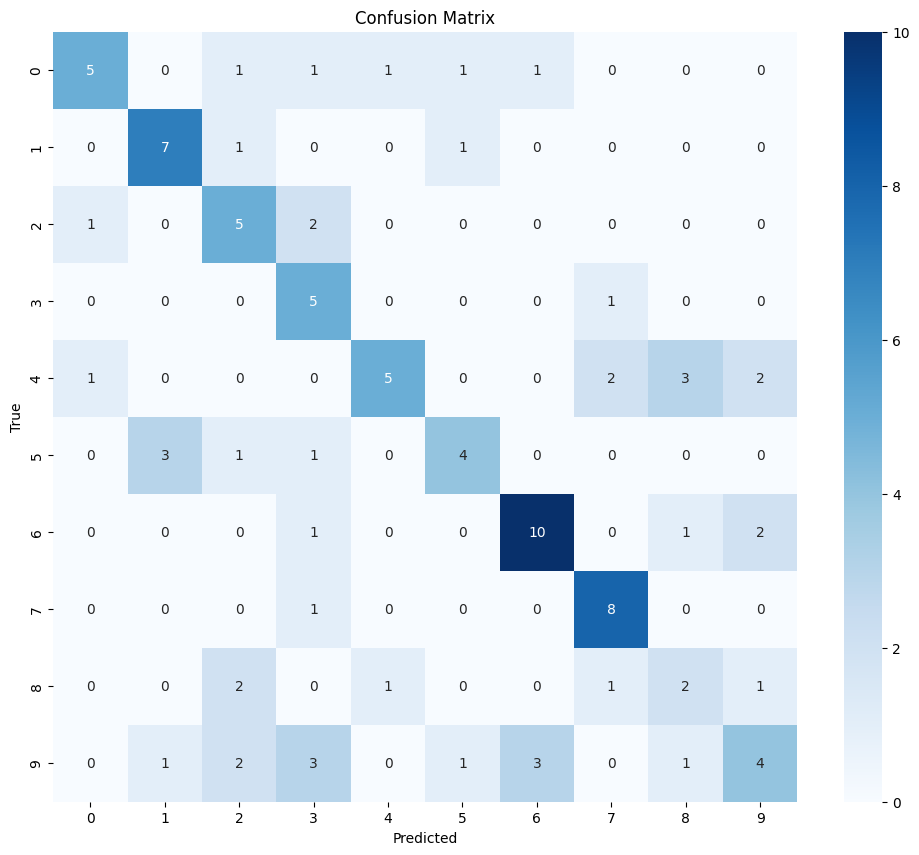

In [42]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[inv_label_mapping[i] for i in range(num_classes)],
            yticklabels=[inv_label_mapping[i] for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Plot training/validation loss

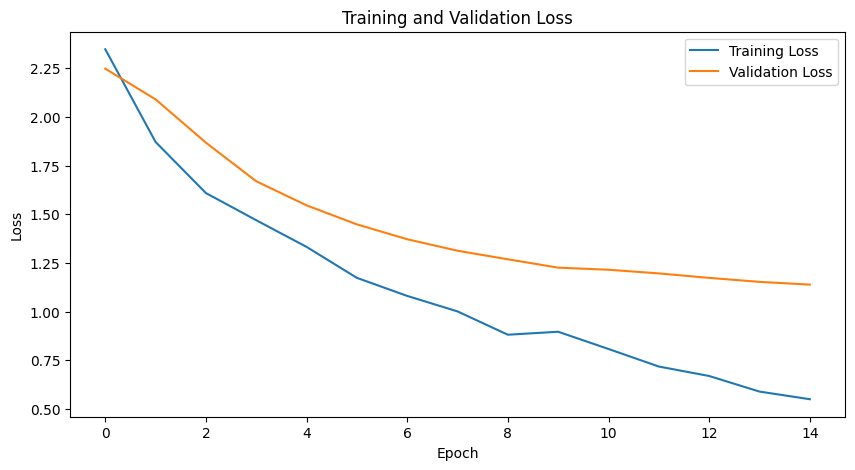

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### Plot validation accuracy

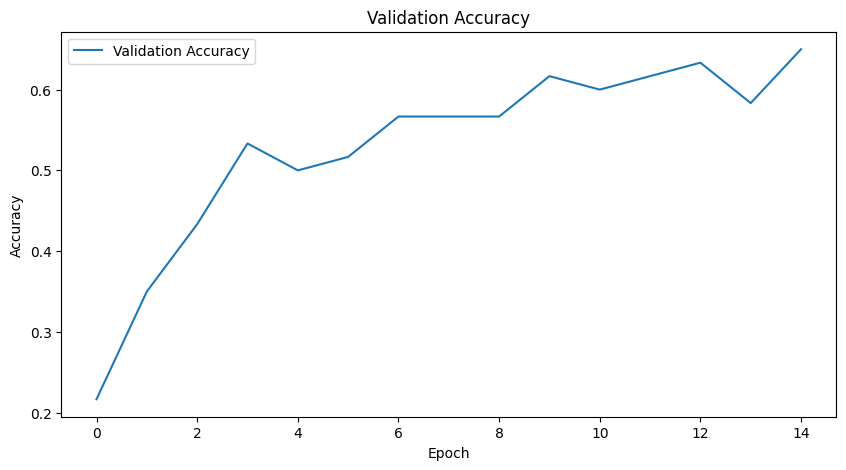

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

#### Save the model

In [45]:
torch.save(model.state_dict(), 'music_genre_classifier.pth')
print("\nModel saved as 'music_genre_classifier.pth'")


Model saved as 'music_genre_classifier.pth'


### Example of using sklearn Pipeline with PyTorch model

In [47]:
import sklearn

In [48]:
class PyTorchWrapper(sklearn.base.BaseEstimator):
    def __init__(self, model, criterion, optimizer, epochs=15, batch_size=32):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
    def fit(self, X, y):
        # Convert data to PyTorch datasets
        dataset = MusicDataset(X, y)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Train the model
        self.model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
            
            print(f'Epoch {epoch+1}/{self.epochs}, Loss: {running_loss/len(dataset):.4f}')
        return self
    
    def predict(self, X):
        # Convert to PyTorch tensor
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        
        # Set model to evaluation mode
        self.model.eval()
        
        # Make predictions
        with torch.no_grad():
            outputs = self.model(X_tensor)
            _, predicted = torch.max(outputs, 1)
        
        return predicted.cpu().numpy()

### Example of how to use the sklearn Pipeline

In [49]:
print("\nExample of using sklearn Pipeline with PyTorch model:")
model_reset = MusicGenreClassifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_reset.parameters(), lr=0.001)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', PyTorchWrapper(model_reset, criterion, optimizer, epochs=5))
])


Example of using sklearn Pipeline with PyTorch model:


### Note: This is just a demonstration - would typically use this on original data
For brevity, we're using already processed data

In [50]:
print("Fitting pipeline...")
pipeline.fit(X_train, y_train_indices)
y_pred = pipeline.predict(X_test)

accuracy_metric = evaluate.load("accuracy")
accuracy = accuracy_metric.compute(predictions=y_pred, references=y_test_indices)
print(f"Pipeline Test Accuracy: {accuracy['accuracy']:.4f}")

Fitting pipeline...
Epoch 1/5, Loss: 2.3428
Epoch 2/5, Loss: 1.8078
Epoch 3/5, Loss: 1.5471
Epoch 4/5, Loss: 1.3884
Epoch 5/5, Loss: 1.2066
Pipeline Test Accuracy: 0.5500


In [51]:
import pickle
import json

#### Save the StandardScaler

In [52]:
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

#### Save the label mapping

In [53]:
with open('label_mapping.json', 'w') as mapping_file:
    json.dump(label_mapping, mapping_file)



### Further improvements you could make:

- Implement k-fold cross-validation
- Try different neural network architectures
- Implement early stopping
- Explore feature importance
- Add data augmentation techniques
- Implement transfer learning using pretrained audio models